In [1]:
from __future__ import print_function, division

import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import random
import numpy as np

### Scraping Site 1: vgchartz.com

In [30]:
# First site has a list of games by unit sales and also includes year released, publisher, platform, and genre in the table.
url = "http://www.vgchartz.com/gamedb/?page={}&results=1000&name=&platform=&minSales=0&publisher=&genre=&sort=GL"

# Only need first 18 pages of results because the remaining games have 0 sales
page_list = list(range(19))
page_list.pop(0)

0

In [1]:
# Grabs data from the 2nd table on the specified page. For vgchartz url this includes unit sales per game. This table
# can be displayed with 25, 50, 100, 200, 500, or 1000 results per page.

def get_table(page, r):
    soup = BeautifulSoup(page, "lxml")
    tables=soup.find_all("table")

    headers = ['Game', 'Platform', 'Year', 'Genre', 'Publisher', 'North_America', 'Europe', 'Japan', 'Rest_of_World', 'Global']
    game_data = []
    rows=[row for row in tables[2].find_all('tr')]
    rows=rows[1:r+1]
    for row in rows:
        items=row.find_all('td')
        game_dict = dict(zip(headers,[i.text for i in items[1:]]))
        game_data.append(game_dict)
    
    df = pd.DataFrame(game_data)
    df = df[['Game', 'Platform', 'Year', 'Genre', 'Publisher', 'North_America', 'Europe', 'Japan', 'Rest_of_World', 'Global']]
    return(df)

In [32]:
# Grabs the table data from pages 1-18 (all games with above 0 global unit sales) for all 1000 rows on each and
# concatinates them into one dataframe.

dfs = []
for page in page_list:
    print(page)
    page_url = url.format(page)
    response = requests.get(page_url)
    page_text = response.text
    dfs.append(get_table(page_text, 1000))
    time.sleep(.5+2*random.random())

df_all = pd.concat(dfs)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [34]:
df_all = df_all.reset_index()
df_all.to_csv('sales.csv')
df_all.head()

,index,Game,Platform,Year,Genre,Publisher,North_America,Europe,Japan,Rest_of_World,Global
0,0,Wii Sports,Wii,2006,Sports,Nintendo,41.36,28.96,3.77,8.45,82.54
1,1,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.69,12.85,3.80,3.29,35.63
3,3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.61,10.95,3.29,2.95,32.79
4,4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


### Scraping Site 2: metacritic.com

In [11]:
from fake_useragent import UserAgent
ua = UserAgent()
user_agent = {'User-agent': ua.random}

In [22]:
# Second site starts with a list of all their games that have critic ratings. Each page has only 100 results.
# I'll scrape every page of this list to get the links for all the individual game pages.
url2 = 'http://www.metacritic.com/browse/games/score/metascore/all/all/filtered?page={}'

page_list2 = list(range(146))

In [23]:
# Grabs the link for every product item listed on the page.
def get_links(page):
    soup = BeautifulSoup(page, "lxml")
    links = [x.find('a')['href'] for x in soup.find_all(class_='product_item product_title')]
    return(links)

In [24]:
# Loops through every page of the initial list to grab all product page links.

links = []
for page in page_list2:
    print(page)
    page_url = url2.format(page)
    user_agent = {'User-agent': ua.random}
    response = requests.get(page_url, headers = user_agent)
    page_text = response.text
    links += get_links(page_text)
    time.sleep(.5+2*random.random())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145


In [25]:
len(links)

14535

In [28]:
# Checking that I only pulled links for individual game sites
res = [i for i in links if '/game' in i]
len(res)

14535

In [29]:
# Write scraped links to a new txt file.
with open("links.txt", "w") as f:
    for l in links:
        f.write(str(l) +"\n")

In [56]:
# Now I'll loop through all the individual game sites to grab the pieces information that I need for each game.
# Given the runtime of my code to scrape the data off each individual game page, I had to split it up and ran it
# over 3 separate times.

with open("links.txt", "r") as f:
    links = f.read().split('\n')
links = links[0:7500]

url3 = 'http://www.metacritic.com/{}'

In [57]:
# Grabs the game name, platform, metascore (critic score), number of critics, user score, number of users,
# developer, genre, ESRB rating, and number of players for a specific game's product page on metacritic.
# Stores it in a dictionary. 

def get_game_data(page):
    soup = BeautifulSoup(page, "lxml")
    
    game = soup.find(class_='product_title').span.text.strip()
    platform = soup.find(class_='platform').span.text.strip()
    metascore = [x.find_all('span') for x in soup.find_all(class_='score_summary metascore_summary')][0][0].text
    user_score = [soup.find_all(class_='metascore_w')][0][5].text
    
    ratings_summary = [x.find('a') for x in soup.find_all(class_='summary')]
    critics = ratings_summary[0].text.strip().split('\n')[0]
    try:
        users = ratings_summary[1].text.split(' ')[0]
    except:
        users = ''
    
    try:
        developer = [x.find_all('span') for x in soup.find_all(class_='summary_detail developer')][0][1].text.strip()
    except:
        developer = ''
    
    try:
        genre_details = [x.find_all('span') for x in soup.find_all(class_='summary_detail product_genre')]
        genres = []
        for i in genre_details[0]:
            genres += i
        genres.pop(0)
    except:
        genre = ''
    
    try:
        rating = [x.find_all('span') for x in soup.find_all(class_='summary_detail product_rating')][0][1].text.strip()
    except:
        rating = ''
    
    try:
        players = [x.find_all('span') for x in soup.find_all(class_='summary_detail product_players')][0][1].text.strip()
    except:
        players = ''

    game_dict = {'Game': game, 'Platform': platform, 'Metascore': metascore, 'User_score': user_score, 'Critics': critics, 'Users': users, 'Developer': developer, 'Genres': genres, 'Players': players, 'Rating': rating}
    return(game_dict)

In [58]:
# Runs through the list of product page links collected previously and grabs the data for each game off the product
# page. Stored as a list of game dictionaries to make converting to pandas dataframe easier later. Prints every 100
# links as a counter and prints any links that didn't work.

game_data = []
counter = 0
for link in links:
    counter +=1
    if counter %100 == 0:
        print(counter)
    page_url = url3.format(link)
    response = requests.get(page_url, headers = user_agent)
    page_text = response.text
    try:
        game_data.append(get_game_data(page_text))
    except:
        print(link)
    time.sleep(.5+2*random.random())

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
/game/3ds/3d-fantasy-zone-ii-w
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
/game/playstation-3/rochard
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
/game/playstation-2/unreal-tournament
4800
/game/pc/magic-the-gathering---duels-of-the-planeswalkers-2012
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
/game/pc/driftmoon
6600
6700
6800
6900
7000
7100
7200
7300
7400
/game/3ds/tomodachi-life
7500


In [59]:
df = pd.DataFrame(game_data)
df.to_csv('scores.csv')

In [60]:
# Grabs game data for next batch of links.

with open("links.txt", "r") as f:
    links = f.read().split('\n')
links = links[7500:10000]

In [61]:
counter = 0
for link in links:
    counter +=1
    if counter %100 == 0:
        print(counter)
    page_url = url3.format(link)
    response = requests.get(page_url, headers = user_agent)
    page_text = response.text
    try:
        game_data.append(get_game_data(page_text))
    except:
        print(link)
    time.sleep(.5+2*random.random())

100
200
300
400
500
600
/game/xbox-360/lips-number-one-hits
700
800
900
1000
1100
1200
1300
1400
/game/xbox-360/ea-sports-active-2
1500
1600
1700
/game/xbox-360/wreckateer
1800
1900
2000
/game/psp/black-rock-shooter-the-game
2100
2200
2300
2400
2500


In [62]:
df = pd.DataFrame(game_data)
df.to_csv('scores2.csv')

In [63]:
# Grabs game data for last batch of links.

with open("links.txt", "r") as f:
    links = f.read().split('\n')
links = links[10000:]

In [64]:
counter = 0
for link in links:
    counter +=1
    if counter %100 == 0:
        print(counter)
    page_url = url3.format(link)
    response = requests.get(page_url, headers = user_agent)
    page_text = response.text
    try:
        game_data.append(get_game_data(page_text))
    except:
        print(link)
    time.sleep(.5+2*random.random())

/game/wii/defend-your-castle
100
/game/playstation-3/matt-hazard-blood-bath-and-beyond
200
300
400
500
/game/playstation-3/beat-hazard-ultra
600
700
/game/pc/puzzle-agent-2
800
/game/playstation-2/pinball-hall-of-fame-the-gottlieb-collection
900
1000
1100
/game/xbox/king-arthur
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
/game/ds/retro-atari-classics
3300
3400
/game/xbox/backyard-wrestling-dont-try-this-at-home
3500
3600
3700
/game/pc/nightcry
3800
/game/wii-u/animal-crossing-amiibo-festival
3900
4000
4100
4200
4300
4400
4500



In [65]:
df = pd.DataFrame(game_data)
df.to_csv('scores3.csv')

In [66]:
# Grabs game data for all the printed error links that, when I visited them manually, weren't 404 errors.

stalled_links = ['/game/playstation-3/rochard', '/game/playstation-2/unreal-tournament', '/game/pc/magic-the-gathering---duels-of-the-planeswalkers-2012', '/game/pc/driftmoon', '/game/3ds/tomodachi-life', '/game/xbox-360/lips-number-one-hits', '/game/xbox-360/ea-sports-active-2', '/game/xbox-360/wreckateer', '/game/psp/black-rock-shooter-the-game', '/game/wii/defend-your-castle', '/game/playstation-3/matt-hazard-blood-bath-and-beyond', '/game/playstation-3/beat-hazard-ultra', '/game/pc/puzzle-agent-2', '/game/xbox/king-arthur', '/game/ds/retro-atari-classics', '/game/xbox/backyard-wrestling-dont-try-this-at-home', '/game/wii-u/animal-crossing-amiibo-festival']
counter = 0
for link in stalled_links:
    counter +=1
    if counter %100 == 0:
        print(counter)
    page_url = url3.format(link)
    response = requests.get(page_url, headers = user_agent)
    page_text = response.text
    try:
        game_data.append(get_game_data(page_text))
    except:
        print(link)
    time.sleep(.5+2*random.random())

In [67]:
df = pd.DataFrame(game_data)
df.to_csv('scores_final.csv')

In [9]:
# Checking how many unique genre values there are in the second dataset. After realizing there were 169, I chose to
# drop this genre data and solely use the genre data from the other site.
genres = [d['Genres'] for d in game_data]
unique_genres = [item for sublist in genres for item in sublist]
len(set(unique_genres))

NameError: name 'game_data' is not defined

### Examine and Clean Data

In [386]:
with open("scores_final.csv", "r") as f:
    df_scores = pd.DataFrame.from_csv(f)

In [387]:
with open("sales.csv", "r") as f:
    df_sales = pd.DataFrame.from_csv(f)

In [389]:
df_scores.head()

,Critics,Developer,Game,Genres,Metascore,Platform,Players,Rating,User_score,Users
0,22,Nintendo,The Legend of Zelda: Ocarina of Time,"['Action Adventure', 'Fantasy']",99,Nintendo 64,1 Player,E,9.2,3736.0
1,19,Neversoft Entertainment,Tony Hawk's Pro Skater 2,"['Sports', 'Alternative', 'Skateboarding']",98,PlayStation,1-2,T,7.4,368.0
2,64,Rockstar North,Grand Theft Auto IV,"['Action Adventure', 'Modern', 'Modern']",98,PlayStation 3,1 Player,M,7.5,2968.0
3,24,Namco,SoulCalibur,"['Action', 'Fighting', '3D']",98,Dreamcast,1-2,T,8.6,225.0
4,86,Rockstar North,Grand Theft Auto IV,"['Action Adventure', 'Modern', 'Modern']",98,Xbox 360,1 Player,M,7.9,3019.0


In [175]:
df_sales.head()

,index,Game,Platform,Year,Genre,Publisher,North_America,Europe,Japan,Rest_of_World,Global
0,0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.54
1,1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.69,12.85,3.80,3.29,35.63
3,3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.95,3.29,2.95,32.79
4,4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [176]:
df_sales.Genre.unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy', nan], dtype=object)

In [177]:
df_scores.Rating.unique()

array(['E', 'T', 'M', 'E10+', nan, 'AO', 'K-A', 'RP'], dtype=object)

In [178]:
# Comparing the Platform values across both sites before normalizing across data sets.
len(df_scores.Platform.unique())

19

In [179]:
len(df_sales.Platform.unique())

32

In [180]:
df_scores.Platform.unique()

array(['Nintendo 64', 'PlayStation', 'PlayStation 3', 'Dreamcast',
       'Xbox 360', 'Wii', 'Xbox One', 'Switch', 'PlayStation 2',
       'PlayStation 4', 'GameCube', 'Xbox', 'PC', 'Wii U',
       'Game Boy Advance', '3DS', 'DS', 'PlayStation Vita', 'PSP'], dtype=object)

In [181]:
df_sales.Platform.unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'PS4',
       'GBA', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'WiiU',
       'XOne', 'GC', 'GEN', 'NS', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG',
       'TG16', '3DO', 'GG', 'PCFX'], dtype=object)

In [182]:
# Create dictionary of old values for platforms in the scores dataframe mapped to new values to match the platform 
# names in the sales dataframe

platform_dict = {'Nintendo 64': 'N64', 'PlayStation': 'PS', 'PlayStation 3': 'PS3', 'Dreamcast': 'DC',
       'Xbox 360': 'X360', 'Xbox One': 'XOne', 'Switch': 'NS', 'PlayStation 2': 'PS2',
       'PlayStation 4': 'PS4', 'GameCube': 'GC', 'Xbox': 'XB', 'Wii U': 'WiiU',
       'Game Boy Advance': 'GBA', 'PlayStation Vita': 'PSV'}

df_scores = df_scores.replace({"Platform": platform_dict})

In [183]:
df_scores.Platform.unique()

array(['N64', 'PS', 'PS3', 'DC', 'X360', 'Wii', 'XOne', 'NS', 'PS2', 'PS4',
       'GC', 'XB', 'PC', 'WiiU', 'GBA', '3DS', 'DS', 'PSV', 'PSP'], dtype=object)

In [184]:
# Convert game names in scores dataframe to lowercase without punctioation before using as part of the unique key.
df_scores['game'] = df_scores['Game'].str.lower()
df_scores['game'] = df_scores['game'].str.replace('[^\w\s]','')

df_scores['key'] = df_scores['game'] + df_scores['Platform']

In [185]:
df_scores.head()

,Critics,Developer,Game,Genres,Metascore,Platform,Players,Rating,User_score,Users,game,key
0,22,Nintendo,The Legend of Zelda: Ocarina of Time,"['Action Adventure', 'Fantasy']",99,N64,1 Player,E,9.2,3736.0,the legend of zelda ocarina of time,the legend of zelda ocarina of timeN64
1,19,Neversoft Entertainment,Tony Hawk's Pro Skater 2,"['Sports', 'Alternative', 'Skateboarding']",98,PS,1-2,T,7.4,368.0,tony hawks pro skater 2,tony hawks pro skater 2PS
2,64,Rockstar North,Grand Theft Auto IV,"['Action Adventure', 'Modern', 'Modern']",98,PS3,1 Player,M,7.5,2968.0,grand theft auto iv,grand theft auto ivPS3
3,24,Namco,SoulCalibur,"['Action', 'Fighting', '3D']",98,DC,1-2,T,8.6,225.0,soulcalibur,soulcaliburDC
4,86,Rockstar North,Grand Theft Auto IV,"['Action Adventure', 'Modern', 'Modern']",98,X360,1 Player,M,7.9,3019.0,grand theft auto iv,grand theft auto ivX360


In [186]:
# Complete the same process for the game names of the sales dataframe before joining the two dfs using the key.

df_sales['game'] = df_sales['Game'].str.lower()
df_sales["game"] = df_sales['game'].str.replace('[^\w\s]','')

df_sales['key'] = df_sales['game'] + df_sales['Platform']

In [187]:
df_sales.head()

,index,Game,Platform,Year,Genre,Publisher,North_America,Europe,Japan,Rest_of_World,Global,game,key
0,0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.54,wii sports,wii sportsWii
1,1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,super mario bros,super mario brosNES
2,2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.69,12.85,3.80,3.29,35.63,mario kart wii,mario kart wiiWii
3,3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.95,3.29,2.95,32.79,wii sports resort,wii sports resortWii
4,4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,pokemon redpokemon blue,pokemon redpokemon blueGB


In [188]:
df_joined = df_sales.merge(df_scores, on='key', how='inner')
df_joined.head()

,index,Game_x,Platform_x,Year,Genre,Publisher,North_America,Europe,Japan,Rest_of_World,...,Developer,Game_y,Genres,Metascore,Platform_y,Players,Rating,User_score,Users,game_y
0,0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,...,Nintendo,Wii Sports,"['Sports', 'General', 'General']",76,Wii,1-4,E,8.0,348.0,wii sports
1,2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.69,12.85,3.80,3.29,...,Nintendo,Mario Kart Wii,"['Driving', 'Racing', 'Arcade', 'Kart', 'Kart'...",82,Wii,2 Online,E,8.3,760.0,mario kart wii
2,3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.95,3.29,2.95,...,Nintendo,Wii Sports Resort,"['Sports', 'General', 'General']",80,Wii,1-4,E,7.9,203.0,wii sports resort
3,6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.15,6.50,2.88,...,Nintendo,New Super Mario Bros.,"['Action', 'Platformer', 'Platformer', '2D', '...",89,DS,1-4,E,8.5,467.0,new super mario bros
4,7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,...,Nintendo,Wii Play,"['Miscellaneous', 'Party', 'Party', 'Party / M...",58,Wii,1-2,E,6.5,133.0,wii play


In [189]:
len(df_joined)

7915

In [190]:
df_joined = df_joined.rename(columns = {'Game_x':'Game', 'Platform_x':'Device', 'game_x': 'game'})

In [191]:
# After checking Developer versus Publisher, I decided to use only Publisher and drop Developer because the latter had
# too many subcategories to be useful.

len(df_scores.Developer.unique())

3231

In [192]:
len(df_sales.Publisher.unique())

634

In [193]:
# Dropping redundant columns that were identical across data sets or where one was better/cleaner. I also chose to drop
# Players because it would have been difficult to clean up and likely provided little additional predictive value to
# my models.

df_cleaned = df_joined.drop(['index','Game_y', 'Platform_y', 'game_y', 'Players', 'Developer', 'Genres', 'game'], 1)

In [194]:
df_cleaned.head()

,Game,Device,Year,Genre,Publisher,North_America,Europe,Japan,Rest_of_World,Global,key,Critics,Metascore,Rating,User_score,Users
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.54,wii sportsWii,51,76,E,8.0,348.0
1,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.69,12.85,3.80,3.29,35.63,mario kart wiiWii,73,82,E,8.3,760.0
2,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.95,3.29,2.95,32.79,wii sports resortWii,73,80,E,7.9,203.0
3,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.15,6.50,2.88,29.81,new super mario brosDS,65,89,E,8.5,467.0
4,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,wii playWii,41,58,E,6.5,133.0


In [195]:
df_cleaned.isnull().sum()

Game               0
Device             0
Year             138
Genre              0
Publisher         13
North_America      0
Europe             0
Japan              0
Rest_of_World      0
Global             0
key                0
Critics            0
Metascore          0
Rating            71
User_score         0
Users            776
dtype: int64

In [196]:
# Converting the null values for Rating to 'Unknown'.

df_cleaned['Rating'] = df_cleaned['Rating'].fillna('Unknown')

In [197]:
df_cleaned['Rating'].value_counts()

T          2664
E          2568
M          1556
E10+       1051
Unknown      71
RP            3
AO            1
K-A           1
Name: Rating, dtype: int64

In [200]:
df_cleaned.loc[df_cleaned["Rating"].isin(['RP', 'AO', 'K-A', 'Unknown']), "Rating"] = "Other"

In [201]:
df_cleaned['Rating'].value_counts()

T        2664
E        2568
M        1556
E10+     1051
Other      76
Name: Rating, dtype: int64

In [202]:
df_cleaned[df_cleaned.Users.isnull()]

,Game,Device,Year,Genre,Publisher,North_America,Europe,Japan,Rest_of_World,Global,key,Critics,Metascore,Rating,User_score,Users
226,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,Namco Bandai Games,2.08,1.35,0.00,0.54,3.98,namco museum 50th anniversaryPS2,21,61,E10+,tbd,NaN
489,uDraw Studio,Wii,2010.0,Misc,THQ,1.65,0.57,0.00,0.20,2.43,udraw studioWii,9,71,E,tbd,NaN
602,The Incredibles,GBA,2004.0,Action,THQ,1.15,0.77,0.04,0.10,2.06,the incrediblesGBA,13,55,E,tbd,NaN
678,High School Musical: Sing It!,PS2,2007.0,Misc,Disney Interactive Studios,0.47,0.08,0.00,1.33,1.87,high school musical sing itPS2,8,56,E,tbd,NaN
752,Tetris Worlds,GBA,2001.0,Puzzle,THQ,1.25,0.39,0.00,0.06,1.71,tetris worldsGBA,10,65,E,tbd,NaN
764,Personal Trainer: Math,DS,2007.0,Puzzle,Nintendo,0.48,1.12,0.00,0.08,1.69,personal trainer mathDS,11,63,E,tbd,NaN
767,World Championship Poker: Featuring Howard Led...,PS2,2006.0,Misc,Oxygen Interactive,0.82,0.64,0.00,0.22,1.68,world championship poker featuring howard lede...,14,53,T,tbd,NaN
857,MySims Kingdom,DS,2008.0,Simulation,Electronic Arts,0.80,0.59,0.01,0.16,1.56,mysims kingdomDS,9,58,E,tbd,NaN
917,Midway Arcade Treasures,PS2,2003.0,Misc,Midway Games,0.72,0.56,0.00,0.19,1.46,midway arcade treasuresPS2,22,76,T,tbd,NaN
924,Wall-E,DS,2008.0,Platform,THQ,0.46,0.82,0.00,0.17,1.46,walleDS,15,54,E,tbd,NaN


In [203]:
df_cleaned[df_cleaned['User_score'] == 'tbd']

,Game,Device,Year,Genre,Publisher,North_America,Europe,Japan,Rest_of_World,Global,key,Critics,Metascore,Rating,User_score,Users
226,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,Namco Bandai Games,2.08,1.35,0.00,0.54,3.98,namco museum 50th anniversaryPS2,21,61,E10+,tbd,NaN
489,uDraw Studio,Wii,2010.0,Misc,THQ,1.65,0.57,0.00,0.20,2.43,udraw studioWii,9,71,E,tbd,NaN
602,The Incredibles,GBA,2004.0,Action,THQ,1.15,0.77,0.04,0.10,2.06,the incrediblesGBA,13,55,E,tbd,NaN
678,High School Musical: Sing It!,PS2,2007.0,Misc,Disney Interactive Studios,0.47,0.08,0.00,1.33,1.87,high school musical sing itPS2,8,56,E,tbd,NaN
752,Tetris Worlds,GBA,2001.0,Puzzle,THQ,1.25,0.39,0.00,0.06,1.71,tetris worldsGBA,10,65,E,tbd,NaN
764,Personal Trainer: Math,DS,2007.0,Puzzle,Nintendo,0.48,1.12,0.00,0.08,1.69,personal trainer mathDS,11,63,E,tbd,NaN
767,World Championship Poker: Featuring Howard Led...,PS2,2006.0,Misc,Oxygen Interactive,0.82,0.64,0.00,0.22,1.68,world championship poker featuring howard lede...,14,53,T,tbd,NaN
857,MySims Kingdom,DS,2008.0,Simulation,Electronic Arts,0.80,0.59,0.01,0.16,1.56,mysims kingdomDS,9,58,E,tbd,NaN
917,Midway Arcade Treasures,PS2,2003.0,Misc,Midway Games,0.72,0.56,0.00,0.19,1.46,midway arcade treasuresPS2,22,76,T,tbd,NaN
924,Wall-E,DS,2008.0,Platform,THQ,0.46,0.82,0.00,0.17,1.46,walleDS,15,54,E,tbd,NaN


In [204]:
df_cleaned.User_score.unique()

array(['8.0', '8.3', '7.9', '8.5', '6.5', '8.4', '8.6', '7.7', '6.3',
       '7.4', '9.0', '7.8', '8.7', '7.1', '3.4', '5.3', '4.9', '3.2',
       '8.9', '6.4', '9.2', '4.8', '8.8', '7.5', '7.2', '2.6', '8.1',
       '7.0', '7.3', '4.3', '8.2', '6.2', '6.6', '7.6', '5.7', '3.6',
       '9.1', '6.9', '5.6', '9.4', '6.8', '6.1', '5.5', '4.0', '5.4',
       '4.2', '9.3', '6.0', '5.2', 'tbd', '6.7', '3.7', '4.4', '4.1',
       '5.8', '5.9', '4.6', '2.9', '5.1', '5.0', '3.3', '4.5', '2.7',
       '1.9', '3.9', '4.7', '2.3', '2.1', '1.8', '3.0', '3.1', '3.5',
       '9.5', '2.8', '3.8', '2.0', '1.7', '2.4', '1.4', '2.2', '1.6', '90',
       '2.5', '0.5', '0.6', '0.9', '1.2', '1.0', '1.5', '0.7'], dtype=object)

In [205]:
df_cleaned.Year.unique()

array([ 2006.,  2008.,  2009.,  2005.,  2007.,  2010.,  2013.,  2004.,
        2002.,  2014.,  2001.,  2011.,  2012.,  1996.,  2016.,  1997.,
        1999.,  2015.,  1998.,  2003.,  2000.,  2017.,    nan,  1992.,
        1988.])

In [206]:
# Given that all the instances where User is NaN, User_score is 'tbd', I will delete all these NaN records. These
# games are generally either older or have low enough sales that they would not provide good data points anyway.
# I will also delete all games where year is missing since this is important to normalizing sales across time.
# Lastly, I'll delete all records with unknown Publishers since this will also be an important predictor.

df_cleaned.dropna(axis=0, how='any', inplace=True)

In [207]:
# Checking there are no more tbd values for User_score
len(df_cleaned[df_cleaned['User_score'] == 'tbd'])

0

In [208]:
# Checking all the null values have been cleaned up.
df_cleaned.isnull().sum()

Game             0
Device           0
Year             0
Genre            0
Publisher        0
North_America    0
Europe           0
Japan            0
Rest_of_World    0
Global           0
key              0
Critics          0
Metascore        0
Rating           0
User_score       0
Users            0
dtype: int64

In [209]:
df_cleaned.dtypes

Game              object
Device            object
Year             float64
Genre             object
Publisher         object
North_America    float64
Europe           float64
Japan            float64
Rest_of_World    float64
Global           float64
key               object
Critics           object
Metascore         object
Rating            object
User_score        object
Users            float64
dtype: object

In [210]:
df_cleaned.Metascore.unique()

array(['76', '82', '80', '89', '58', '87', '91', '61', '97', '95', '77',
       '88', '83', '85', '94', '93', '86', '98', '96', '90', '84', '78',
       '73', '74', '92', '71', '72', '68', '62', '67', '99', '49', '79',
       '81', '66', '70', '56', '59', '64', '75', '60', '63', '65', '69',
       '50', '25', '57', '44', '48', '29', '47', '54', '55', '20', '53',
       '33', '38', '52', '43', '45', '40', '46', '51', '39', '42', '32',
       '41', '34', '36', '31', '27', '35', '26', '28', '23', '37', '30',
       '24', '17', '22'], dtype=object)

In [211]:
df_cleaned.Critics.unique()

array(['51', '73', '65', '41', '80', '64', '63', '45', '33', '50', '58',
       '62', '66', '37', '54', '81', '89', '21', '100', '39', '56', '57',
       '86', '13', '74', '42', '16', '82', '67', '70', '29', '15', '99',
       '87', '20', '23', '113', '24', '10', '27', '91', '53', '75', '36',
       '22', '84', '38', '34', '12', '14', '90', '97', '44', '105', '77',
       '68', '46', '96', '94', '61', '47', '88', '98', '85', '8', '95',
       '35', '17', '52', '11', '19', '48', '83', '72', '78', '30', '69',
       '76', '18', '101', '40', '109', '9', '32', '55', '79', '25', '59',
       '26', '49', '60', '31', '108', '115', '43', '28', '107', '7', '71',
       '92', '93', '103', '102', '110', '106', '104'], dtype=object)

In [212]:
# After to checking to make sure there aren't any text values for User_score, Metascore, or Critics, I can just
# just convert them to float values before moving to modeling.

df_cleaned['User_score'] = df_cleaned['User_score'].str.replace('','').astype(np.float64)
df_cleaned['Metascore'] = df_cleaned['Metascore'].str.replace('','').astype(np.float64)
df_cleaned['Critics'] = df_cleaned['Critics'].str.replace('','').astype(np.float64)

In [213]:
df_cleaned.dtypes

Game              object
Device            object
Year             float64
Genre             object
Publisher         object
North_America    float64
Europe           float64
Japan            float64
Rest_of_World    float64
Global           float64
key               object
Critics          float64
Metascore        float64
Rating            object
User_score       float64
Users            float64
dtype: object

In [214]:
df_cleaned.shape

(7015, 16)

In [215]:
df_cleaned.to_csv('games_cleaned.csv')

### Modeling

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

from sklearn.linear_model import LinearRegression, Lasso, LassoCV

In [3]:
with open("games_cleaned.csv", "r") as f:
    df = pd.DataFrame.from_csv(f)

In [4]:
df.head()

,Game,Device,Year,Genre,Publisher,North_America,Europe,Japan,Rest_of_World,Global,key,Critics,Metascore,Rating,User_score,Users
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.54,wii sportsWii,51.0,76.0,E,8.0,348.0
1,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.69,12.85,3.80,3.29,35.63,mario kart wiiWii,73.0,82.0,E,8.3,760.0
2,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.95,3.29,2.95,32.79,wii sports resortWii,73.0,80.0,E,7.9,203.0
3,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.15,6.50,2.88,29.81,new super mario brosDS,65.0,89.0,E,8.5,467.0
4,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,wii playWii,41.0,58.0,E,6.5,133.0


In [5]:
df.shape

(7015, 16)

In [6]:
df.describe()

,Year,North_America,Europe,Japan,Rest_of_World,Global,Critics,Metascore,User_score,Users
count,7015.000000,7015.000000,7015.000000,7015.000000,7015.000000,7015.000000,7015.000000,7015.000000,7015.000000,7015.000000
mean,2007.549822,0.402503,0.244281,0.068284,0.083629,0.798968,30.345545,71.187741,7.222081,191.181468
std,4.452172,0.976977,0.699461,0.290568,0.270221,1.982809,18.908935,13.242489,1.364059,620.562563
min,1988.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,17.000000,0.500000,4.000000
25%,2004.000000,0.050000,0.020000,0.000000,0.010000,0.110000,16.000000,63.000000,6.600000,13.000000
50%,2007.000000,0.150000,0.060000,0.000000,0.020000,0.290000,26.000000,73.000000,7.500000,31.000000
75%,2011.000000,0.400000,0.220000,0.020000,0.070000,0.780000,41.000000,81.000000,8.200000,105.000000
max,2017.000000,41.360000,28.960000,6.500000,10.570000,82.540000,115.000000,99.000000,9.500000,11574.000000


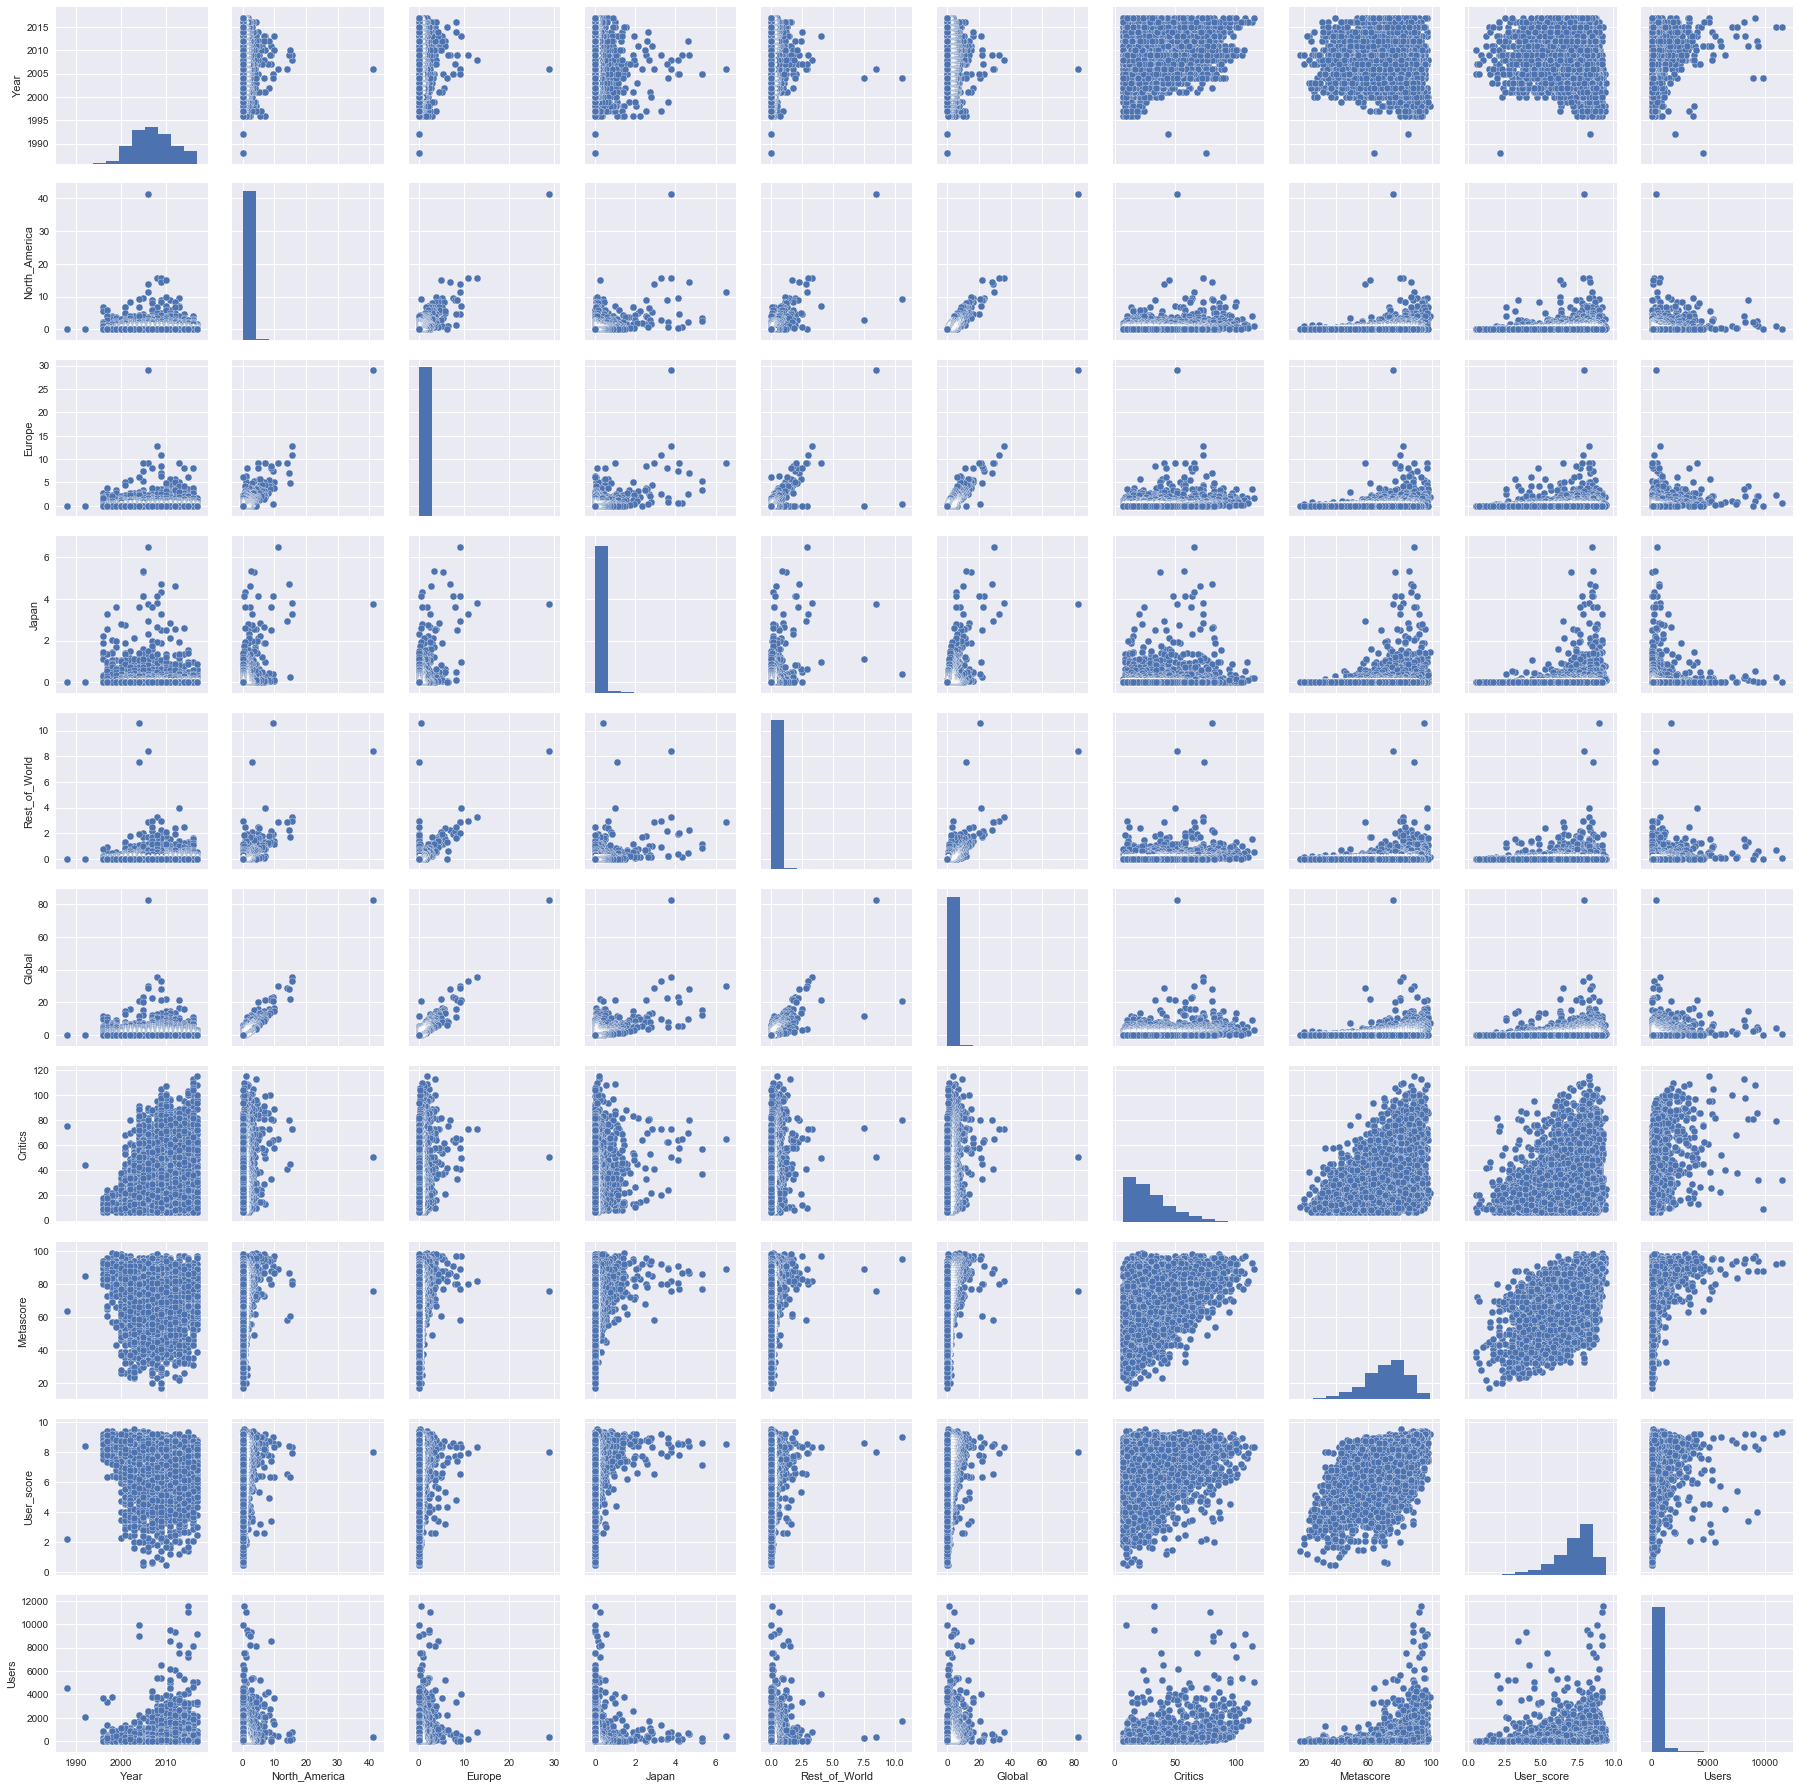

In [7]:
sns.pairplot(df)

In [8]:
df.Genre.value_counts()

Action          1625
Sports           911
Shooter          906
Role-Playing     762
Racing           588
Platform         425
Fighting         388
Misc             380
Strategy         323
Simulation       301
Adventure        267
Puzzle           139
Name: Genre, dtype: int64

In [9]:
df.Rating.value_counts()

T        2444
E        2058
M        1510
E10+      935
Other      68
Name: Rating, dtype: int64

In [10]:
df.Device.value_counts()

PS2     1134
X360     847
PC       775
PS3      759
XB       574
Wii      452
DS       444
PSP      377
GC       346
PS4      330
GBA      222
XOne     181
3DS      170
PS       131
PSV      107
WiiU      77
N64       61
NS        15
DC        13
Name: Device, dtype: int64

In [11]:
len(df.Publisher.unique())

276

In [12]:
df.Publisher.value_counts().head(30)

Electronic Arts                           927
Ubisoft                                   482
Activision                                467
Nintendo                                  354
Sony Computer Entertainment               353
Sega                                      322
THQ                                       294
Take-Two Interactive                      268
Konami Digital Entertainment              256
Namco Bandai Games                        242
Capcom                                    202
Atari                                     178
Microsoft Game Studios                    150
Tecmo Koei                                141
Square Enix                               140
Eidos Interactive                         129
Warner Bros. Interactive Entertainment    120
Codemasters                               118
Vivendi Games                             113
Midway Games                              109
505 Games                                  82
Deep Silver                       

In [13]:
top30 = list(df.Publisher.value_counts().index)[:30]

In [14]:
# Bucketing all publishers after the top 30 into one bucket given the drastic drop in size after that
df.loc[~df["Publisher"].isin(top30), "Publisher"] = "Other"

In [15]:
df = df.drop(['North_America', 'Europe', 'Japan', 'Rest_of_World'], 1)

In [16]:
df.shape

(7015, 12)

In [17]:
# Trying an interaction between number of users contributing to an average user score and number of critics contributing
# to an average metascore.

df['US_Users'] = df['Users'] * df['User_score']
df['Metascore_Critics'] = df['Critics'] * df['Metascore']

In [18]:
# Creat dummies for all my categorical variables of interest

df_genres = pd.get_dummies(df['Genre'])
df_device = pd.get_dummies(df['Device'])
df_rating = pd.get_dummies(df['Rating'])
df_publisher = pd.get_dummies(df['Publisher'])

In [19]:
df = pd.concat([df, df_genres, df_device, df_rating, df_publisher], axis=1)
df.head()

,Game,Device,Year,Genre,Publisher,Global,key,Critics,Metascore,Rating,...,Rising Star Games,Sega,Sony Computer Entertainment,Square Enix,THQ,Take-Two Interactive,Tecmo Koei,Ubisoft,Vivendi Games,Warner Bros. Interactive Entertainment
0,Wii Sports,Wii,2006.0,Sports,Nintendo,82.54,wii sportsWii,51.0,76.0,E,...,0,0,0,0,0,0,0,0,0,0
1,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.63,mario kart wiiWii,73.0,82.0,E,...,0,0,0,0,0,0,0,0,0,0
2,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,32.79,wii sports resortWii,73.0,80.0,E,...,0,0,0,0,0,0,0,0,0,0
3,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,29.81,new super mario brosDS,65.0,89.0,E,...,0,0,0,0,0,0,0,0,0,0
4,Wii Play,Wii,2006.0,Misc,Nintendo,28.92,wii playWii,41.0,58.0,E,...,0,0,0,0,0,0,0,0,0,0


In [20]:
df.shape

(7015, 81)

In [24]:
selected_col = ['Year', 'Metascore','User_score', 'Metascore_Critics', 'US_Users', 'Action',
       'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle', 'Racing',
       'Role-Playing', 'Shooter', 'Simulation', 'Sports', '3DS',
       'DC', 'DS', 'GBA', 'GC', 'N64', 'NS', 'PC', 'PS', 'PS2', 'PS3', 'PS4',
       'PSP', 'PSV', 'Wii', 'WiiU', 'X360', 'XB', 'XOne', 'E', 'E10+', 'M',
       'T', '505 Games', 'Acclaim Entertainment', 'Activision',
       'Atari', 'Bethesda Softworks', 'Capcom', 'Codemasters', 'D3Publisher',
       'Deep Silver', 'Disney Interactive Studios', 'Eidos Interactive',
       'Electronic Arts', 'Focus Home Interactive',
       'Konami Digital Entertainment', 'LucasArts', 'Microsoft Game Studios',
       'Midway Games', 'Namco Bandai Games', 'Nintendo',
       'Nippon Ichi Software', 'Other', 'Rising Star Games', 'Sega',
       'Sony Computer Entertainment', 'Square Enix', 'THQ',
       'Take-Two Interactive', 'Tecmo Koei', 'Ubisoft', 'Vivendi Games']

In [34]:
X=df.drop(['Game', 'Device', 'Genre', 'Publisher', 'Rating', 'key', 'Global'], 1)

y=df['Global']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [36]:
lr_model1 = LinearRegression()
lr_model1.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [37]:
sorted(list(zip(X,lr_model1.coef_)), key=lambda x: x[1], reverse=True)

[('Nintendo', 1.8323364215133007),
 ('Wii', 0.92372543966065046),
 ('PS', 0.70367729454009376),
 ('LucasArts', 0.48761549429960471),
 ('XOne', 0.43552794212174678),
 ('PS4', 0.39745612195273888),
 ('PS3', 0.37239750628425522),
 ('Warner Bros. Interactive Entertainment', 0.32574939908021128),
 ('PS2', 0.28806307172817558),
 ('Other', 0.27963307434929019),
 ('Sports', 0.23987972613088948),
 ('Bethesda Softworks', 0.23553918698015719),
 ('Activision', 0.22443618990459924),
 ('Simulation', 0.20534670765393903),
 ('Misc', 0.19552174916729431),
 ('Take-Two Interactive', 0.1771670396482761),
 ('Racing', 0.16647906918229904),
 ('PSV', 0.15511597328464727),
 ('X360', 0.14001848179803419),
 ('Platform', 0.1380216456555316),
 ('Fighting', 0.12795981985224819),
 ('Focus Home Interactive', 0.096119157722957912),
 ('Action', 0.094002925814760413),
 ('E', 0.075478593393772234),
 ('PSP', 0.074603861693674334),
 ('N64', 0.070429999208412461),
 ('Microsoft Game Studios', 0.069432304133443076),
 ('DS', 0

In [38]:
test_set_pred = lr_model1.predict(X_test)

In [39]:
lr_model1.score(X_train, y_train)

0.24009697936251151

In [40]:
lr_model1.score(X_test, y_test)

0.26834557152585437

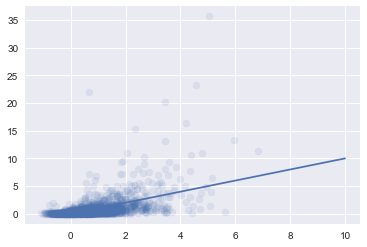

In [41]:
m

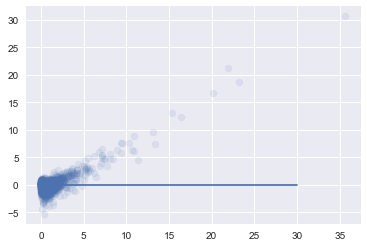

In [42]:
# Plot residuals
plt.scatter(y_test,y_test-test_set_pred,alpha=.1);
plt.plot(np.linspace(0,30,100),np.linspace(0,0, 100))

In [43]:
from sklearn.metrics import r2_score

In [44]:
#Just testing out r2 from sklearn
r2_score(y_test, test_set_pred)

0.26834557152585437

In [45]:
lr_model1.score(X_test,y_test)

0.26834557152585437

In [46]:
# Better score on test data suggest I'm underfitting
lr_model1.score(X_train,y_train)

0.24009697936251151

In [47]:
np.sqrt(np.mean((test_set_pred - y_test)**2))

1.4979210394834572

In [48]:
alphavec = 10**np.linspace(-3,9,27)
alphavec

array([  1.00000000e-03,   2.89426612e-03,   8.37677640e-03,
         2.42446202e-02,   7.01703829e-02,   2.03091762e-01,
         5.87801607e-01,   1.70125428e+00,   4.92388263e+00,
         1.42510267e+01,   4.12462638e+01,   1.19377664e+02,
         3.45510729e+02,   1.00000000e+03,   2.89426612e+03,
         8.37677640e+03,   2.42446202e+04,   7.01703829e+04,
         2.03091762e+05,   5.87801607e+05,   1.70125428e+06,
         4.92388263e+06,   1.42510267e+07,   4.12462638e+07,
         1.19377664e+08,   3.45510729e+08,   1.00000000e+09])

In [49]:
lr_model2 = LassoCV(alphas = alphavec, cv=5)
lr_model2.fit(X_train,y_train)

LassoCV(alphas=array([  1.00000e-03,   2.89427e-03,   8.37678e-03,   2.42446e-02,
         7.01704e-02,   2.03092e-01,   5.87802e-01,   1.70125e+00,
         4.92388e+00,   1.42510e+01,   4.12463e+01,   1.19378e+02,
         3.45511e+02,   1.00000e+03,   2.89427e+03,   8.37678e+03,
         2.42446e+04,   7.01704e+04,   2.03092e+05,   5.87802e+05,
         1.70125e+06,   4.92388e+06,   1.42510e+07,   4.12463e+07,
         1.19378e+08,   3.45511e+08,   1.00000e+09]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [50]:
lr_model2.alpha_

0.001

In [51]:
list(zip(X,lr_model2.coef_))

[('Year', -0.052098725049065334),
 ('Critics', -0.065246948675071553),
 ('Metascore', -0.00099096509439964339),
 ('User_score', -0.084451086950232748),
 ('Users', 0.00091062360980247756),
 ('US_Users', -5.0806953749277107e-05),
 ('Metascore_Critics', 0.0010657782111357923),
 ('Action', -0.0),
 ('Adventure', -0.298692725094994),
 ('Fighting', 0.0),
 ('Misc', 0.07339951883001769),
 ('Platform', 0.009797370810334792),
 ('Puzzle', -0.66565499343019507),
 ('Racing', 0.041395629589271746),
 ('Role-Playing', -0.27988566146804256),
 ('Shooter', -0.036953090653973238),
 ('Simulation', 0.075274596790004783),
 ('Sports', 0.12799230540932902),
 ('Strategy', -0.27171281022255583),
 ('3DS', -0.13380769262871328),
 ('DC', -0.31731941533039792),
 ('DS', -0.0),
 ('GBA', -0.43718124774194295),
 ('GC', -0.56959044535633752),
 ('N64', 0.0),
 ('NS', -0.0),
 ('PC', -0.66666848686504721),
 ('PS', 0.5961570024245284),
 ('PS2', 0.2137540370335351),
 ('PS3', 0.28602940223656864),
 ('PS4', 0.27998433829775998),


In [52]:
# Lasso didn't score any better
lr_model2.score(X_test,y_test)

0.26728078366255847

In [53]:
test_set_pred2 = lr_model2.predict(X_test)

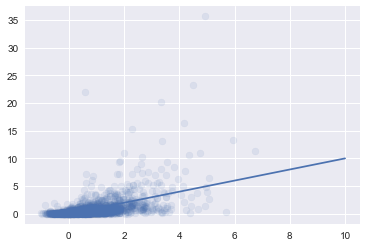

In [54]:
plt.scatter(test_set_pred2,y_test,alpha=.1)
plt.plot(np.linspace(0,10,100),np.linspace(0,10,100));

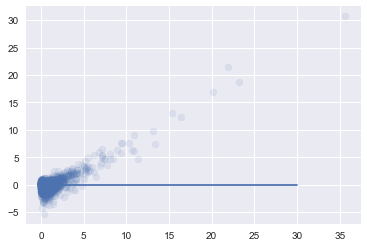

In [55]:
# Plot residuals
plt.scatter(y_test,y_test-test_set_pred2,alpha=.1)
plt.plot(np.linspace(0,30,100),np.linspace(0,0,100));

In [56]:
lr_model2.alpha_

0.001

In [59]:
# Trying standardizing features
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [60]:
std = StandardScaler()

In [61]:
X_tr = std.fit_transform(X_train)
X_te = std.transform(X_test)

In [62]:
lr_model3 = LassoCV(alphas = alphavec, cv=5)
lr_model3.fit(X_tr,y_train)

LassoCV(alphas=array([  1.00000e-03,   2.89427e-03,   8.37678e-03,   2.42446e-02,
         7.01704e-02,   2.03092e-01,   5.87802e-01,   1.70125e+00,
         4.92388e+00,   1.42510e+01,   4.12463e+01,   1.19378e+02,
         3.45511e+02,   1.00000e+03,   2.89427e+03,   8.37678e+03,
         2.42446e+04,   7.01704e+04,   2.03092e+05,   5.87802e+05,
         1.70125e+06,   4.92388e+06,   1.42510e+07,   4.12463e+07,
         1.19378e+08,   3.45511e+08,   1.00000e+09]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [64]:
# No difference
lr_model3.score(X_te,y_test)

0.26862737429052319

The residuals in both models shows a clear pattern and suggest a non-linear relationship would be a better fit for this dataset. Next, I'll try polynomial features.

In [65]:
from sklearn import preprocessing

In [66]:
poly2 = preprocessing.PolynomialFeatures(degree=2)

In [67]:
X_train_poly2 = poly2.fit_transform(X_train)

In [68]:
X_test_poly2 = poly2.transform(X_test)

In [69]:
std = StandardScaler()

In [70]:
X_tr_poly = std.fit_transform(X_train_poly2)
X_te_poly = std.transform(X_test_poly2)

In [71]:
lr_model2.fit(X_tr_poly2,y_train)

/Users/mac/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


LassoCV(alphas=array([  1.00000e-03,   2.89427e-03,   8.37678e-03,   2.42446e-02,
         7.01704e-02,   2.03092e-01,   5.87802e-01,   1.70125e+00,
         4.92388e+00,   1.42510e+01,   4.12463e+01,   1.19378e+02,
         3.45511e+02,   1.00000e+03,   2.89427e+03,   8.37678e+03,
         2.42446e+04,   7.01704e+04,   2.03092e+05,   5.87802e+05,
         1.70125e+06,   4.92388e+06,   1.42510e+07,   4.12463e+07,
         1.19378e+08,   3.45511e+08,   1.00000e+09]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [72]:
# Poly model does a little better
lr_model2.score(X_te_poly2, y_test)

0.35441606619021626

In [73]:
lr_model2.alpha_

0.070170382867038292

In [74]:
test_set_pred3 = lr_model2.predict(X_te_poly)

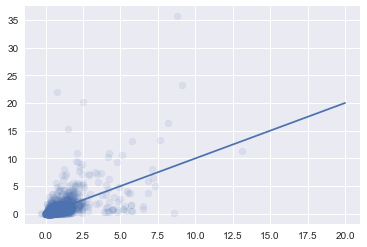

In [75]:
plt.scatter(test_set_pred3,y_test,alpha=.1)
plt.plot(np.linspace(0,20,100),np.linspace(0,20,100));

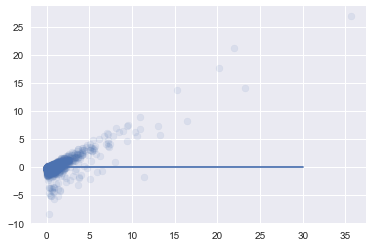

In [76]:
# Plot residuals and still see a pattern
plt.scatter(y_test,y_test-test_set_pred3,alpha=.1)
plt.plot(np.linspace(0,30,100),np.linspace(0,0,100));

In [77]:
poly3 = preprocessing.PolynomialFeatures(degree=3)

In [78]:
X_train_poly3 = poly3.fit_transform(X_train)

In [79]:
X_test_poly3 = poly3.transform(X_test)

In [80]:
std = StandardScaler()

In [81]:
X_tr_poly3 = std.fit_transform(X_train_poly3)
X_te_poly3 = std.transform(X_test_poly3)

In [82]:
lr_model4 = LinearRegression()
lr_model4.fit(X_tr_poly3,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [84]:
lr_model4.score(X_te_poly3, y_test)

-29945628.325439338

### Random Forest

In [130]:
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

In [86]:
rfmodel1 = RandomForestRegressor(n_estimators = 2000, min_samples_leaf=2, max_features=30, n_jobs=-1)
rfmodel1.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=30, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

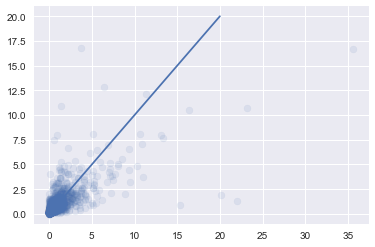

In [88]:
rf1_test_pred = rfmodel1.predict(X_test)
plt.scatter(y_test, rf1_test_pred, alpha=.1)
plt.plot(np.linspace(0,20,100),np.linspace(0,20,100));

In [89]:
np.sqrt(np.mean((rf1_test_pred - y_test)**2))

1.2543928298532192

In [90]:
# Scores much better than either linnear or poly models
rfmodel1.score(X_test, y_test)

0.48690794512046465

In [91]:
rfmodel1.score(X_train, y_train)

0.76119768773953123

In [92]:
sorted(list(zip(X_train.columns, rfmodel1.feature_importances_)), key=lambda x: x[1], reverse=True)

[('US_Users', 0.14982801457266823),
 ('Users', 0.1345843073932288),
 ('Metascore_Critics', 0.10693626728301418),
 ('Metascore', 0.091229685193436175),
 ('Wii', 0.078648793828588484),
 ('Year', 0.073088203684166131),
 ('Critics', 0.052870472211993792),
 ('User_score', 0.050673706993022656),
 ('PC', 0.045662125678276121),
 ('Nintendo', 0.037529441003214925),
 ('Sports', 0.035159008318307927),
 ('E', 0.031806135854158903),
 ('Activision', 0.012137428079785077),
 ('PS2', 0.011622859278607402),
 ('Misc', 0.0068272342975580057),
 ('Platform', 0.0066457814819550869),
 ('Electronic Arts', 0.0065080718064326687),
 ('Take-Two Interactive', 0.0064695561741923814),
 ('DS', 0.0049687462086749996),
 ('X360', 0.0045985953601701711),
 ('Shooter', 0.00449742688393567),
 ('Action', 0.0042510213628017225),
 ('Racing', 0.0041611087951152646),
 ('PS3', 0.0034907157683364202),
 ('T', 0.0033623547293793392),
 ('PS', 0.0031616688648817854),
 ('M', 0.0026794243798737771),
 ('PS4', 0.0022587428743169272),
 ('Ro

### Gradient Boosted Random Forest

In [93]:
from sklearn.ensemble import GradientBoostingRegressor

In [94]:
gbmodel1 = GradientBoostingRegressor(n_estimators=3000, learning_rate=.005, max_depth=5, subsample=.7)

In [95]:
gbmodel1.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.005, loss='ls', max_depth=5,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3000, presort='auto', random_state=None,
             subsample=0.7, verbose=0, warm_start=False)

In [96]:
y_pred_gb1 = gbmodel1.predict(X_test)

In [97]:
y_pred_gb1 = gbmodel1.predict(X_test)
np.sqrt(np.mean((y_pred_gb1 - y_test)**2))

1.2733779984244173

In [98]:
# Doesn't do better initially, but close
gbmodel1.score(X_test, y_test)

0.4712591710975208

In [99]:
sorted(list(zip(X_train.columns, gbmodel1.feature_importances_)), key=lambda x: x[1], reverse=True)

[('US_Users', 0.12743406785777356),
 ('Users', 0.10728895337554363),
 ('Metascore_Critics', 0.096212391627511787),
 ('Metascore', 0.08678487064730353),
 ('Year', 0.0792448127791167),
 ('User_score', 0.066179087006538337),
 ('Wii', 0.060217175931143167),
 ('Critics', 0.054361946338246842),
 ('Sports', 0.029160696647579362),
 ('E', 0.023502416697676758),
 ('Nintendo', 0.023261677690279547),
 ('PC', 0.019097346965481026),
 ('PS2', 0.016110234461896304),
 ('DS', 0.015627473396310154),
 ('Misc', 0.01351891707762662),
 ('Electronic Arts', 0.010788086177704227),
 ('Activision', 0.0093567897274185602),
 ('Racing', 0.0090594154114461943),
 ('PS3', 0.0079701571582446867),
 ('Take-Two Interactive', 0.0076923608629507062),
 ('X360', 0.0073349945987342341),
 ('Ubisoft', 0.0070345048603777747),
 ('Shooter', 0.0069772194826383431),
 ('E10+', 0.0061998296716599529),
 ('PS', 0.0057229436807087449),
 ('Simulation', 0.0055785661108937925),
 ('Action', 0.005330221085751213),
 ('PSP', 0.0049694271960092186

In [100]:
import matplotlib.pyplot as plt
%matplotlib inline

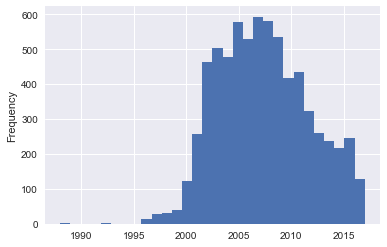

In [101]:
df['Year'].plot.hist(bins=30);

''

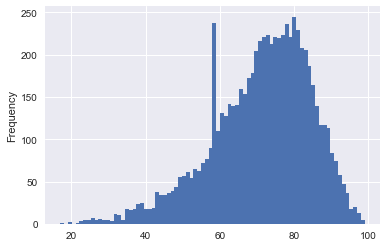

In [104]:
df['Metascore'].plot.hist(bins=80)
;

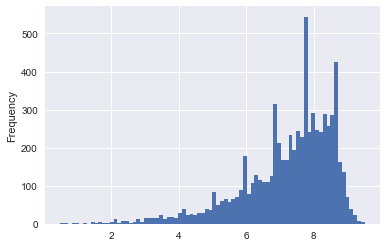

In [105]:
df['User_score'].plot.hist(bins=80);

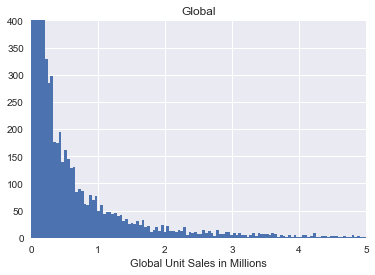

In [110]:
df.hist(column='Global', bins=2000)
plt.xlim(0, 5)
plt.ylim(0, 400)
plt.xlabel('Global Unit Sales in Millions')

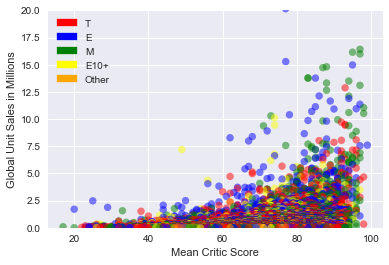

In [117]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='T')
blue_patch = mpatches.Patch(color='blue', label='E')
green_patch = mpatches.Patch(color='green', label='M')
yellow_patch = mpatches.Patch(color='yellow', label='E10+')
orange_patch = mpatches.Patch(color='orange', label='Other')
plt.legend(handles=[red_patch, blue_patch, green_patch, yellow_patch, orange_patch])

colors = {'T':'red', 'E':'blue', 'M':'green', 'E10+':'yellow', 'Other':'orange'}

plt.scatter(df['Metascore'], df['Global'], c=df['Rating'].apply(lambda x: colors[x]), alpha=.5)
plt.ylim(0, 20)
plt.ylabel('Global Unit Sales in Millions')
plt.xlabel('Mean Critic Score');

In [111]:
df.Global.value_counts()

0.02     211
0.01     202
0.04     176
0.05     167
0.03     164
0.07     159
0.09     158
0.06     155
0.08     150
0.11     149
0.10     133
0.15     130
0.14     126
0.13     117
0.19     113
0.12     112
0.17     104
0.21      96
0.18      93
0.16      92
0.20      91
0.24      82
0.23      79
0.28      73
0.29      73
0.22      72
0.25      72
0.26      71
0.27      69
0.32      62
        ... 
21.95      1
3.90       1
5.13       1
4.94       1
14.81      1
22.70      1
5.79       1
10.52      1
5.17       1
3.91       1
4.20       1
3.36       1
3.32       1
8.17       1
6.03       1
3.47       1
4.02       1
7.74       1
9.39       1
2.80       1
10.30      1
9.49       1
10.40      1
3.42       1
20.81      1
13.50      1
4.25       1
3.79       1
2.95       1
13.75      1
Name: Global, Length: 555, dtype: int64

In [112]:
len(df[df["Global"] > 20])

13

In [113]:
len(df[df["Global"] < 1])/len(df.Global)

0.8011404133998574

In [114]:
len(df[df["Global"] > 5])/len(df.Global)

0.022095509622238062

In [115]:
df.Metascore.median()

73.0

In [116]:
df.User_score.median()

7.5

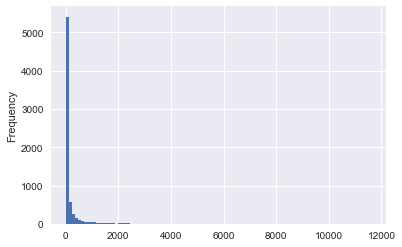

In [106]:
df['Users'].plot.hist(bins=100);

In [108]:
max(df['Users'])

11574.0

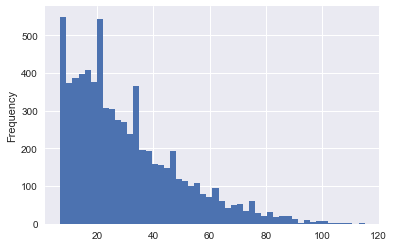

In [109]:
df['Critics'].plot.hist(bins=50);

Realized that Users and Critics were dominating my model, but wouldn't make for reasonable features in a business setting. A game having more users means that there are more people who already own the game (reverse causality) and so that data wouldn't be available to predict sales of the game prior to the sales occuring.

Reran the models below excluding all columns with Users or Critics.

In [133]:
from sklearn import linear_model,ensemble, tree, model_selection
from sklearn.grid_search import GridSearchCV

/Users/mac/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/mac/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [118]:
df.columns

Index(['Game', 'Device', 'Year', 'Genre', 'Publisher', 'Global', 'key',
       'Critics', 'Metascore', 'Rating', 'User_score', 'Users', 'US_Users',
       'Metascore_Critics', 'Action', 'Adventure', 'Fighting', 'Misc',
       'Platform', 'Puzzle', 'Racing', 'Role-Playing', 'Shooter', 'Simulation',
       'Sports', 'Strategy', '3DS', 'DC', 'DS', 'GBA', 'GC', 'N64', 'NS', 'PC',
       'PS', 'PS2', 'PS3', 'PS4', 'PSP', 'PSV', 'Wii', 'WiiU', 'X360', 'XB',
       'XOne', 'E', 'E10+', 'M', 'Other', 'T', '505 Games',
       'Acclaim Entertainment', 'Activision', 'Atari', 'Bethesda Softworks',
       'Capcom', 'Codemasters', 'D3Publisher', 'Deep Silver',
       'Disney Interactive Studios', 'Eidos Interactive', 'Electronic Arts',
       'Focus Home Interactive', 'Konami Digital Entertainment', 'LucasArts',
       'Microsoft Game Studios', 'Midway Games', 'Namco Bandai Games',
       'Nintendo', 'Nippon Ichi Software', 'Other', 'Rising Star Games',
       'Sega', 'Sony Computer Entertainment', 

In [190]:
selected_col = ['Year', 'Metascore','User_score', 'Action',
       'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle', 'Racing',
       'Role-Playing', 'Shooter', 'Simulation', 'Sports','3DS',
       'DS', 'GBA', 'GC', 'N64', 'NS', 'PC', 'PS', 'PS2', 'PS3', 'PS4',
       'PSP', 'PSV', 'Wii', 'WiiU', 'X360', 'XB', 'XOne', 'E', 'E10+', 'M',
       'T', '505 Games', 'Acclaim Entertainment', 'Activision',
       'Atari', 'Bethesda Softworks', 'Capcom', 'Codemasters', 'D3Publisher',
       'Deep Silver', 'Disney Interactive Studios', 'Eidos Interactive',
       'Electronic Arts', 'Focus Home Interactive',
       'Konami Digital Entertainment', 'LucasArts', 'Microsoft Game Studios',
       'Midway Games', 'Namco Bandai Games', 'Nintendo',
       'Nippon Ichi Software', 'Other', 'Rising Star Games', 'Sega',
       'Sony Computer Entertainment', 'Square Enix', 'THQ',
       'Take-Two Interactive', 'Tecmo Koei', 'Ubisoft', 'Vivendi Games']

In [ ]:
# Re-running linnear model withough Users and Critics

In [191]:
lr_model1.fit(X_train.loc[:,selected_col],y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [192]:
lr_model1.score(X_train.loc[:,selected_col], y_train)

0.17175845467703277

In [193]:
lr_model1.score(X_test.loc[:,selected_col], y_test)

0.19138600781395909

In [194]:
sorted(list(zip(X,lr_model1.coef_)), key=lambda x: x[1], reverse=True)

[('PS', 2.2228289337450375),
 ('Electronic Arts', 1.8643137895680195),
 ('N64', 1.8336647278415052),
 ('GC', 1.627901726955761),
 ('PS3', 1.5877288729067556),
 ('DS', 1.5539106877278583),
 ('GBA', 1.464599990253368),
 ('PSP', 1.387748739339681),
 ('3DS', 1.3752535625720195),
 ('Shooter', 1.2688741513982853),
 ('PC', 1.2227458047015989),
 ('NS', 1.2050674152074592),
 ('Role-Playing', 1.1272580844103839),
 ('PS2', 0.92702043091526543),
 ('Strategy', 0.83862563600363671),
 ('DC', 0.70822442052374879),
 ('PS4', 0.67737264762677951),
 ('Simulation', 0.60084146841505071),
 ('Sports', 0.58169048657639122),
 ('Action', 0.38055229693795145),
 ('Fighting', 0.35928580667818139),
 ('User_score', 0.34966548789073004),
 ('Platform', 0.33490236706708104),
 ('US_Users', 0.33186483150763035),
 ('Puzzle', 0.3141905360342746),
 ('Metascore_Critics', 0.28036616503966394),
 ('WiiU', 0.2507590856117865),
 ('Racing', 0.2220641676999601),
 ('Deep Silver', 0.183583744200156),
 ('Konami Digital Entertainment', 

In [120]:
rfmodel2 = RandomForestRegressor(n_estimators = 2000, min_samples_leaf=2, max_features=30, n_jobs=-1)
rfmodel2.fit(X_train.loc[:,selected_col],y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=30, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [121]:
rfmodel2.score(X_train.loc[:,selected_col], y_train)

0.70413985485273434

In [122]:
rfmodel2.score(X_test.loc[:,selected_col], y_test)

0.36438653228634321

In [123]:
sorted(list(zip(X_train.loc[:,selected_col].columns, rfmodel2.feature_importances_)), key=lambda x: x[1], reverse=True)

[('Metascore', 0.28498596003229243),
 ('User_score', 0.13107291481511041),
 ('Year', 0.10593330035012515),
 ('Nintendo', 0.077560050582176548),
 ('Sports', 0.065222987310635555),
 ('Wii', 0.065041173201724756),
 ('E', 0.024844087636480255),
 ('PC', 0.016420248236342118),
 ('Platform', 0.015214358616521569),
 ('Take-Two Interactive', 0.013618837940477788),
 ('PS2', 0.013386442948184578),
 ('Shooter', 0.012715745431303112),
 ('Activision', 0.01232316363417447),
 ('Misc', 0.011264152609388957),
 ('M', 0.010647791815038712),
 ('X360', 0.0099632568131668361),
 ('Action', 0.0087865266852466123),
 ('E10+', 0.0085256689814441605),
 ('DS', 0.0079888444890514696),
 ('Electronic Arts', 0.0079422420400881901),
 ('Sony Computer Entertainment', 0.0078242096173314016),
 ('PS3', 0.0076496136163406864),
 ('T', 0.007018410163298224),
 ('Racing', 0.0064657010486391161),
 ('Microsoft Game Studios', 0.0061481353114980989),
 ('PS4', 0.0059201350187896443),
 ('Other', 0.005025550898233257),
 ('Other', 0.0047

In [124]:
rfmodel3 = RandomForestRegressor(n_estimators = 2000, min_samples_leaf=2, max_features=23, n_jobs=-1)
rfmodel3.fit(X_train.loc[:,selected_col],y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=23, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [127]:
rfmodel3.score(X_test.loc[:,selected_col], y_test)

0.37088928329435211

In [128]:
rfmodel3.score(X_train.loc[:,selected_col], y_train)

0.68768624136376466

In [134]:
params = {
    "n_estimators": [2000],
    "max_features": np.arange(10,30,2),
    "min_samples_leaf": [2, 3, 4]
}

model = ensemble.RandomForestRegressor()
rf_grid_search = GridSearchCV(model, params, n_jobs=-2, cv=5, verbose=1)
rf_grid_search.fit(X_train.loc[:,selected_col],y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-2)]: Done 150 out of 150 | elapsed:  8.6min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-2,
       param_grid={'n_estimators': [2000], 'max_features': array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28]), 'min_samples_leaf': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [135]:
rf_grid_search.score(X_train.loc[:,selected_col],y_train)

0.65564620039917176

In [136]:
rf_grid_search.score(X_test.loc[:,selected_col],y_test)

0.37132256996899282

In [140]:
rf_grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=16, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [166]:
rfmodel4 = RandomForestRegressor(n_estimators = 2000, min_samples_leaf=1, max_features=16, n_jobs=-1)
rfmodel4.fit(X_train.loc[:,selected_col],y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=16, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [167]:
rfmodel4.score(X_test.loc[:,selected_col], y_test)

0.3737714165064937

### Gradient Boosting

In [170]:
gbmodel2 = GradientBoostingRegressor(n_estimators=3000, learning_rate=.01, max_depth=2, subsample=.9)

In [171]:
gbmodel2.fit(X_train.loc[:,selected_col],y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=3000,
             presort='auto', random_state=None, subsample=0.9, verbose=0,
             warm_start=False)

In [172]:
gbmodel2.score(X_test.loc[:,selected_col], y_test)

0.27686916036420761

In [173]:
gbmodel2.score(X_train.loc[:,selected_col], y_train)

0.39043762540307875

In [174]:
sorted(list(zip(X_train.loc[:,selected_col].columns, gbmodel2.feature_importances_)), key=lambda x: x[1], reverse=True)

[('Metascore', 0.2884007299648304),
 ('Nintendo', 0.13529154003619423),
 ('User_score', 0.065592173845843788),
 ('Wii', 0.063835359977563677),
 ('Sports', 0.061054849006866474),
 ('Year', 0.057680146943650194),
 ('PS4', 0.027973637188863615),
 ('Shooter', 0.023316320806754619),
 ('PC', 0.020450257446246498),
 ('Activision', 0.01643319267150168),
 ('E', 0.014867946856020739),
 ('PS2', 0.013463015879393079),
 ('DC', 0.012610622468366981),
 ('N64', 0.012229877370638825),
 ('Puzzle', 0.011788315241637174),
 ('PS3', 0.010288034077732206),
 ('Electronic Arts', 0.010077568666792193),
 ('XB', 0.010015483203406114),
 ('Microsoft Game Studios', 0.0094743968213712743),
 ('GC', 0.0089644519626649339),
 ('Codemasters', 0.0081269363990829225),
 ('Take-Two Interactive', 0.0076550999652885508),
 ('X360', 0.0076249689455351669),
 ('LucasArts', 0.0065174566343777583),
 ('Bethesda Softworks', 0.006450203931654212),
 ('Sony Computer Entertainment', 0.0055943535432276745),
 ('Strategy', 0.00558179167261366

In [175]:
y_pred_gb2 = gbmodel2.predict(X_test.loc[:,selected_col])
np.sqrt(np.mean((y_pred_gb2 - y_test)**2))

1.4891702783638543

In [188]:
from sklearn import linear_model,ensemble, tree, model_selection
from sklearn.grid_search import GridSearchCV

In [177]:
params = {
    "learning_rate": [.05, .01, .001],
    "max_depth": [2, 3, 4, 5],
    "subsample": [.9],
    "n_estimators":[1500]
}

model = ensemble.GradientBoostingRegressor()
grid_search2 = GridSearchCV(model, params, n_jobs=-2, verbose=1)
grid_search2.fit(X_train.loc[:,selected_col],y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-2)]: Done  36 out of  36 | elapsed:  1.4min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=-2,
       param_grid={'learning_rate': [0.05, 0.01, 0.001], 'max_depth': [2, 3, 4, 5], 'subsample': [0.9], 'n_estimators': [1500]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [178]:
grid_search2.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1500,
             presort='auto', random_state=None, subsample=0.9, verbose=0,
             warm_start=False)

In [179]:
grid_search2.score(X_test.loc[:,selected_col], y_test)

0.26801438857241933

In [180]:
grid_search2.score(X_train.loc[:,selected_col], y_train)

0.33874596991484485

In [290]:
params = {
    "learning_rate": [.2, .1, .05, .01, .005],
    "max_depth": [1, 2, 3, 4, 5],
    "subsample": [.6, .7, .8, .9],
    "n_estimators":[1000, 1500, 2000, 2500, 3000]
}

grid_search3 = GridSearchCV(model, params, n_jobs=-2, verbose=1)
grid_search3.fit(X_train.loc[:,selected_col],y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-2)]: Done 786 tasks      | elapsed: 28.9min
[Parallel(n_jobs=-2)]: Done 1236 tasks      | elapsed: 48.7min
[Parallel(n_jobs=-2)]: Done 1500 out of 1500 | elapsed: 60.7min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=-2,
       param_grid={'learning_rate': [0.2, 0.1, 0.05, 0.01, 0.005], 'max_depth': [1, 2, 3, 4, 5], 'subsample': [0.6, 0.7, 0.8, 0.9], 'n_estimators': [1000, 1500, 2000, 2500, 3000]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [291]:
grid_search3.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=1, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=2000,
             presort='auto', random_state=None, subsample=0.9, verbose=0,
             warm_start=False)

In [292]:
grid_search3.score(X_train.loc[:,selected_col], y_train)

0.22938316739871623

In [181]:
gbmodel3 = GradientBoostingRegressor(n_estimators=2000, learning_rate=.01, max_depth=2, subsample=.9)

In [182]:
gbmodel3.fit(X_train.loc[:,selected_col],y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=2000,
             presort='auto', random_state=None, subsample=0.9, verbose=0,
             warm_start=False)

In [183]:
gbmodel3.score(X_test.loc[:,selected_col], y_test)

0.2723120017647751

In [184]:
gbmodel3.score(X_train.loc[:,selected_col], y_train)

0.35997755434035239

Lastly, I'll try feeding coeficients from my linear model into a random forest instead of using dummy variables to see if that improves my model.

In [195]:
coef_dict = dict(zip(X.loc[:,selected_col],lr_model1.coef_))

In [196]:
df['Genre_co'] = df['Genre']
df['Device_co'] = df['Device']
df['Rating_co'] = df['Rating']
df['Publisher_co'] = df['Publisher']

In [197]:
df = df.replace({"Genre_co": coef_dict})
df = df.replace({"Device_co": coef_dict})
df = df.replace({"Rating_co": coef_dict})
df = df.replace({"Publisher_co": coef_dict})

In [199]:
df.head()

,Game,Device,Year,Genre,Publisher,Global,key,Critics,Metascore,Rating,...,THQ,Take-Two Interactive,Tecmo Koei,Ubisoft,Vivendi Games,Warner Bros. Interactive Entertainment,Genre_co,Device_co,Rating_co,Publisher_co
0,Wii Sports,Wii,2006.0,Sports,Nintendo,82.54,wii sportsWii,51.0,76.0,E,...,0,0,0,0,0,0,0.222064,2.22283,0.032931,1.86431
1,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.63,mario kart wiiWii,73.0,82.0,E,...,0,0,0,0,0,0,0.359286,2.22283,0.032931,1.86431
2,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,32.79,wii sports resortWii,73.0,80.0,E,...,0,0,0,0,0,0,0.222064,2.22283,0.032931,1.86431
3,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,29.81,new super mario brosDS,65.0,89.0,E,...,0,0,0,0,0,0,0.380552,1.26887,0.032931,1.86431
4,Wii Play,Wii,2006.0,Misc,Nintendo,28.92,wii playWii,41.0,58.0,E,...,0,0,0,0,0,0,0.280366,2.22283,0.032931,1.86431


In [202]:
df.Genre_co.value_counts()

0.34966548789073004     1625
0.2220641676999601       911
0.33490236706708104      906
0.1462382563157394       762
0.3592858066781814       588
0.38055229693795145      425
0.33186483150763035      388
0.28036616503966394      380
Strategy                 323
0.3141905360342746       301
-0.04574869074925625     267
-0.3679216060181358      139
Name: Genre_co, dtype: int64

In [200]:
selected_col2 = ['Year', 'Metascore','User_score', 'Genre_co', 'Device_co', 'Rating_co', 'Publisher_co']

In [201]:
rfmodel5 = RandomForestRegressor(n_estimators = 2000, min_samples_leaf=1, max_features=16, n_jobs=-1)
rfmodel5.fit(X_train.loc[:,selected_col2],y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [4]:
df['Global_log'] = np.log(df.Global)

/Users/mac/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [207]:
df['Global_log']

0       4.413283
1       3.573188
2       3.490124
3       3.394844
4       3.364533
5       3.346389
6       3.145445
7       3.122365
8       3.088767
9       3.081451
10      3.058237
11      3.035434
12      3.003204
13      2.798500
14      2.781920
15      2.771964
16      2.727199
17      2.706716
18      2.695303
19      2.689886
20      2.624669
21      2.622492
22      2.621039
23      2.602690
24      2.589267
25      2.572612
26      2.555676
27      2.537657
28      2.495682
29      2.494857
          ...   
7878        -inf
7879        -inf
7880        -inf
7881        -inf
7882        -inf
7883        -inf
7885        -inf
7886        -inf
7888        -inf
7890        -inf
7891        -inf
7892        -inf
7893        -inf
7895        -inf
7896        -inf
7897        -inf
7898        -inf
7899        -inf
7900        -inf
7902        -inf
7903        -inf
7904        -inf
7905        -inf
7906        -inf
7907        -inf
7910        -inf
7911        -inf
7912        -i

In [5]:
df = df.replace([-np.inf, np.inf], 0)

In [6]:
df['Global_log']

0       4.413283
1       3.573188
2       3.490124
3       3.394844
4       3.364533
5       3.346389
6       3.145445
7       3.122365
8       3.088767
9       3.081451
10      3.058237
11      3.035434
12      3.003204
13      2.798500
14      2.781920
15      2.771964
16      2.727199
17      2.706716
18      2.695303
19      2.689886
20      2.624669
21      2.622492
22      2.621039
23      2.602690
24      2.589267
25      2.572612
26      2.555676
27      2.537657
28      2.495682
29      2.494857
          ...   
7878    0.000000
7879    0.000000
7880    0.000000
7881    0.000000
7882    0.000000
7883    0.000000
7885    0.000000
7886    0.000000
7888    0.000000
7890    0.000000
7891    0.000000
7892    0.000000
7893    0.000000
7895    0.000000
7896    0.000000
7897    0.000000
7898    0.000000
7899    0.000000
7900    0.000000
7902    0.000000
7903    0.000000
7904    0.000000
7905    0.000000
7906    0.000000
7907    0.000000
7910    0.000000
7911    0.000000
7912    0.0000

In [218]:
X2=df.drop(['Game', 'Device', 'Genre', 'Publisher', 'Rating', 'key', 'Global'], 1)

y2=df['Global_log']

In [219]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3)

In [220]:
rfmodel6 = RandomForestRegressor(n_estimators = 2000, min_samples_leaf=1, max_features=16, n_jobs=-1)
rfmodel6.fit(X2_train.loc[:,selected_col],y2_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=16, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [221]:
rfmodel6.score(X2_test.loc[:,selected_col], y2_test)

0.52731686069240102

In [222]:
rfmodel6.score(X2_train.loc[:,selected_col], y2_train)

0.93181373362917586

In [ ]:
tree.export_graphviz(dtrmodel, out_file='tree.dot',feature_names = X2_train.columns)

In [256]:
sorted(list(zip(X2_train.loc[:,selected_col].columns, rfmodel6.feature_importances_)), key=lambda x: x[1], reverse=True)

[('Metascore', 0.21910092844954526),
 ('User_score', 0.10829973368112455),
 ('Year', 0.10426354842021701),
 ('PC', 0.093596265421991481),
 ('Other', 0.053245117333435794),
 ('Nintendo', 0.028934883326740161),
 ('Electronic Arts', 0.016230824641928543),
 ('E', 0.014685586507457623),
 ('M', 0.014368635148660066),
 ('Action', 0.014242315789541689),
 ('T', 0.013664442309409601),
 ('PS2', 0.012692328445573791),
 ('Shooter', 0.012489263261648025),
 ('PS3', 0.01186618854581634),
 ('E10+', 0.010610168161997216),
 ('Misc', 0.010570980959798764),
 ('XB', 0.010411866059346615),
 ('Sega', 0.010056770735002017),
 ('Role-Playing', 0.0098714711644720537),
 ('Racing', 0.0095276691035829746),
 ('Activision', 0.009013873201012549),
 ('Sports', 0.0089680169557666209),
 ('X360', 0.0089183243872825897),
 ('Platform', 0.0086357359242883684),
 ('Simulation', 0.0086273592047939086),
 ('Wii', 0.0085864934363805),
 ('GC', 0.0080375406161659144),
 ('Ubisoft', 0.0079135446616575567),
 ('Adventure', 0.007184719158

In [253]:
gbmodel4 = GradientBoostingRegressor(n_estimators=2000, learning_rate=.1, max_depth=2, subsample=.8)

In [254]:
gbmodel4.fit(X2_train.loc[:,selected_col],y2_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=2000,
             presort='auto', random_state=None, subsample=0.8, verbose=0,
             warm_start=False)

In [255]:
gbmodel4.score(X2_test.loc[:,selected_col], y2_test)

0.52581940110135084

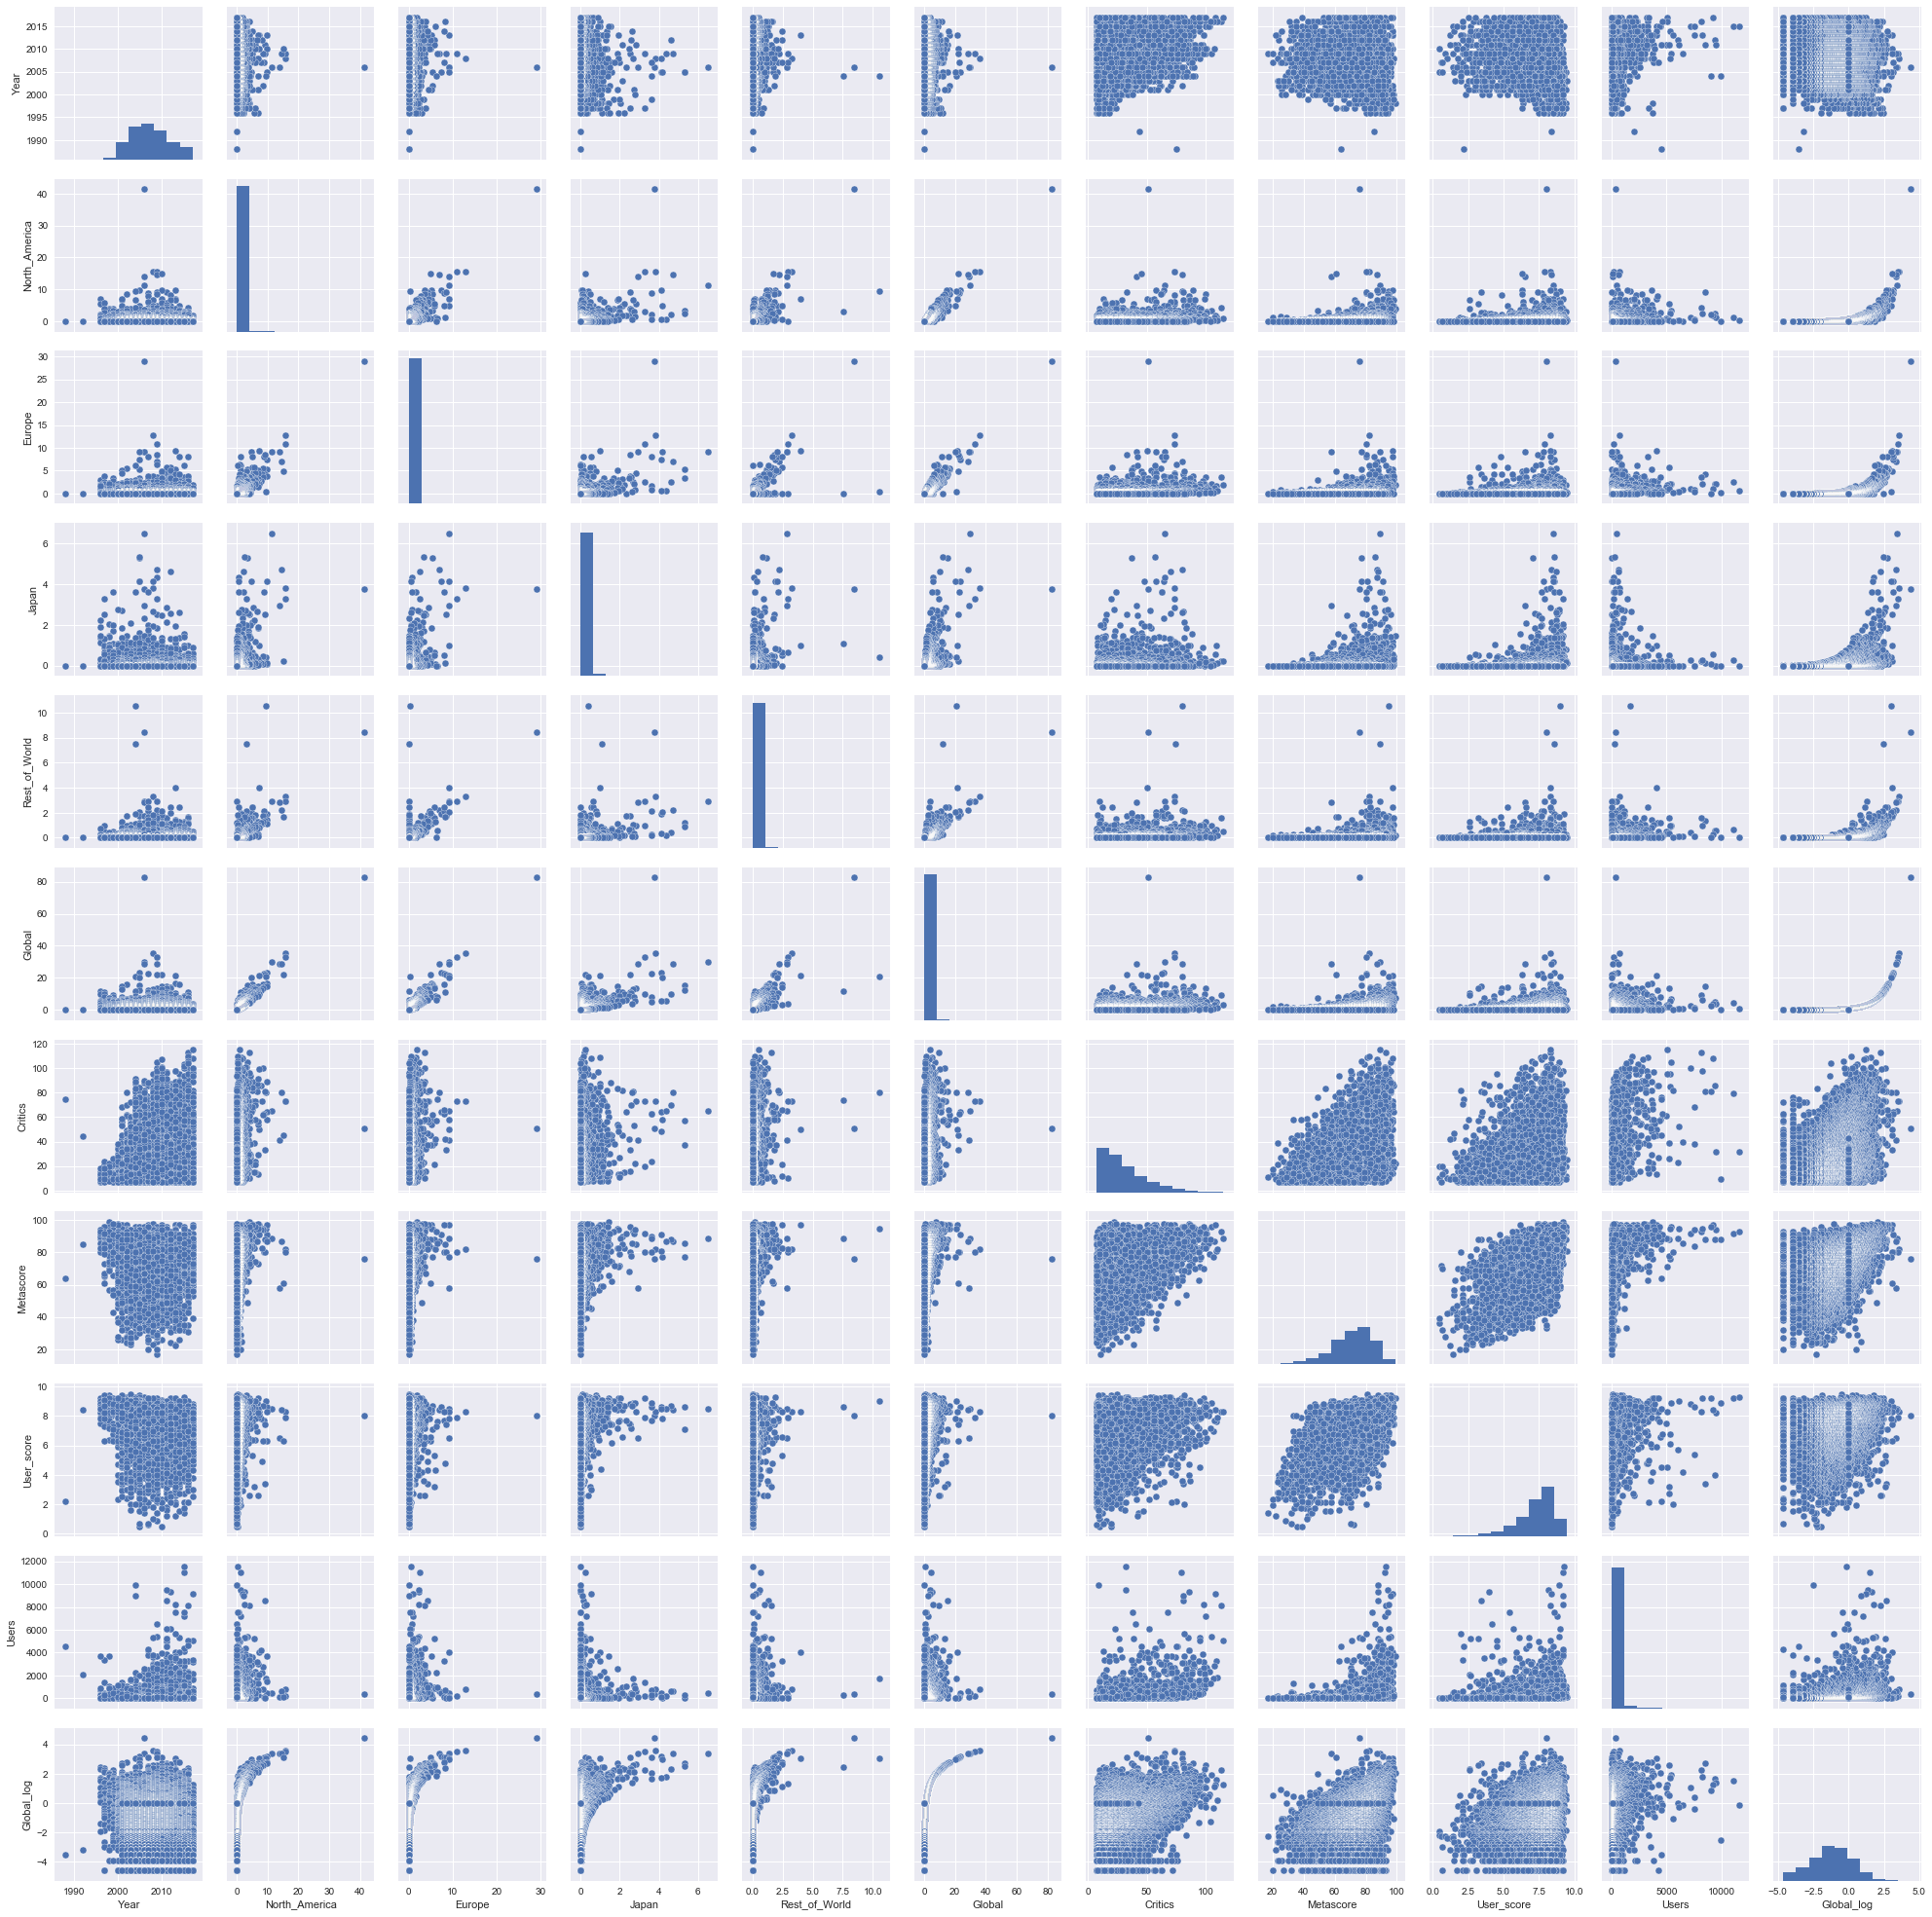

In [12]:
sns.pairplot(df)